# Conditional likelihoods of trajectories

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from scipy import stats, interpolate
from numba import guvectorize,float64

import os

In [2]:
matplotlib.rc_file_defaults()

In [3]:
from analyzer import analyzer

In [4]:
mutual_informations = np.array([np.load('/data/run10/mi.{}.npz'.format(i))['arr_0'] for i in range(70)])

In [6]:
mutual_informations[0,0]

array([[ 1.30706400e-02,  1.69031611e-02,  2.87233328e-02, ...,
         2.49918919e+03,  2.49921825e+03,  2.49934483e+03],
       [ 1.59442456e-05,  2.25664704e-05, -3.68546200e-05, ...,
         7.34391177e+00,  7.34803732e+00,  7.35672271e+00]])

In [7]:
mutual_informations.shape

(70, 50, 2, 100000)

In [8]:
num_s, num_r, _, length = mutual_informations.shape

In [9]:
x = np.linspace(np.max(mutual_informations[:,:,0,0]),np.min(mutual_informations[:,:,0,-1]),1000)
mi = np.zeros((num_s * num_r, len(x)))
for i, old in enumerate(np.reshape(mutual_informations, (-1, 2, length))):
    mi[i] = np.interp(x, old[0], old[1])
mi = np.reshape(mi, (num_s, num_r, -1))
mi_mean = np.mean(mi, axis=(0,1))

In [10]:
def subset_indices(num_responses, subset_signals, subset_responses):
    assert subset_responses <= num_responses
    indices = np.zeros((subset_signals * subset_responses, 2), dtype=int)
    for s in range(subset_signals):
        for r in range(subset_responses):
            indices[s*subset_responses + r] = [s, r]
    return indices.T
    

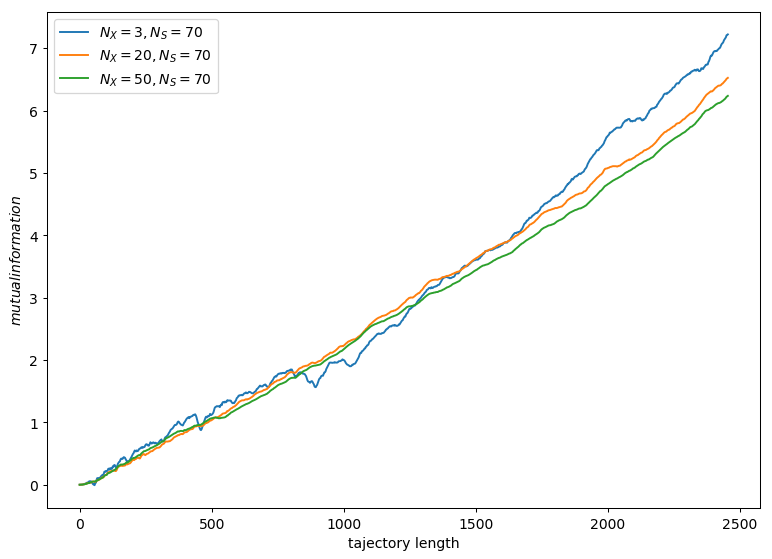

In [13]:
for r in [3,20]:
    indices = subset_indices(num_r, num_s, r)
    subset_mean = np.mean(mi[indices[0], indices[1]], axis=0)
    plt.plot(x, subset_mean, label='$N_X={}, N_S={}$'.format(r, num_s))
plt.plot(x, mi_mean, label='$N_X={}, N_S={}$'.format(num_r, num_s))
plt.legend();
plt.ylabel('$mutual information$')
plt.xlabel('tajectory length');

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


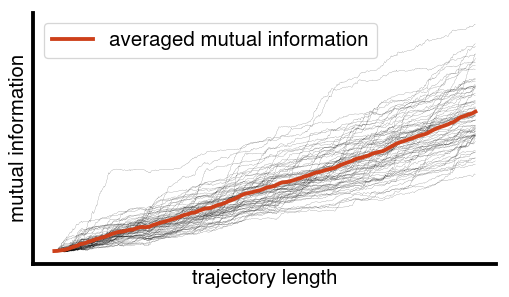

In [49]:
matplotlib.rcParams.update({'font.size': 16, 'font.family': 'TeX Gyre Heros'})
for val in mi:
    plt.plot(x, np.mean(val, axis=0), linewidth=0.1, color='black')
plt.plot(x, mi_mean, label='averaged mutual information'.format(num_r, num_s), linewidth=3, color='#CD401A')

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.tick_params('both', left = False, labelleft=False, bottom=False, labelbottom=False)
plt.ylabel('mutual information')
plt.xlabel('trajectory length')
plt.legend()

plt.gcf().set_size_inches(16.5/2.54, 9.0/2.54)
plt.savefig('poster_plot_3.pdf')

In [12]:
def mut_inf(lamda, rho):
    return lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
from scipy.optimize import curve_fit
def linear(t, inf_rate, offset):
    return t * inf_rate + offset

(rate, offset), _ = curve_fit(linear, x, mi_mean, sigma=np.exp(-x/2500))
theoretical_rate = mut_inf(0.005, 0.005)
print(rate, theoretical_rate)

0.0025801907506283845 0.0010355339059327378


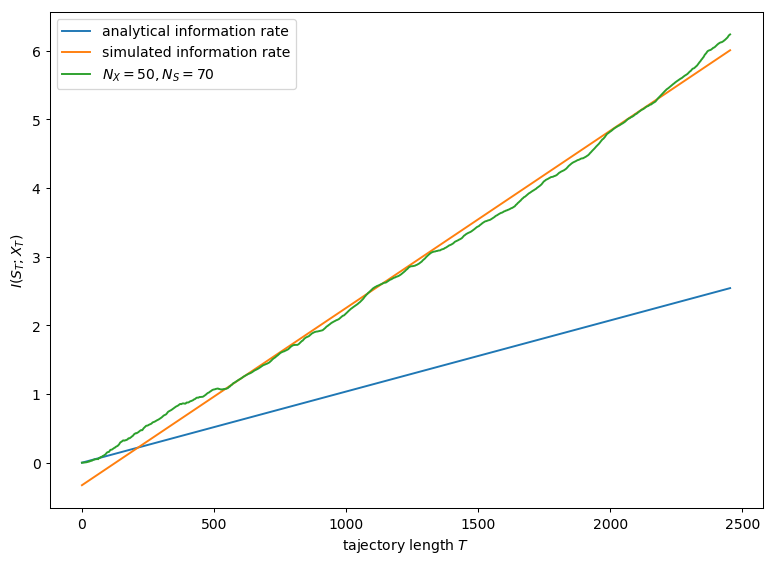

In [17]:
plt.plot(x, theoretical_rate*x, label='analytical information rate')
plt.plot(x, linear(x, rate, offset), label='simulated information rate')
plt.plot(x, mi_mean, label='$N_X={}, N_S={}$'.format(num_r, num_s))
plt.ylabel('$I(S_T;X_T)$')
plt.xlabel('tajectory length $T$')
plt.legend();

(0, 4)

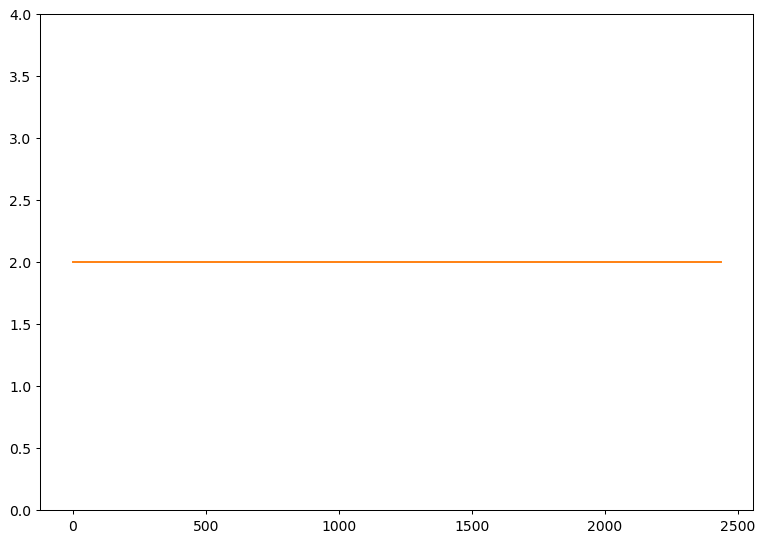

In [74]:
plt.plot(x, (mi_mean - offset) / theoretical_rate / x)
plt.plot(x, np.full_like(x, 2))
plt.ylim(0,4)

In [81]:
from pathlib import Path
signal = analyzer.load_trajectory(Path('/data/signal/sig1.traj'))

In [82]:
responses = []
for i in range(5):
    analyzer.simulate_trajectory('response.inp', '/data/response.traj', ['/data/signal/sig1.traj'], seed=i)
    responses.append(analyzer.load_trajectory(Path('/data/response.traj')))

In [83]:
responses[0]

{'components': {'X': array([ 999.,  998.,  999., ..., 1050., 1049., 1050.])},
 'reaction_events': array([1, 1, 0, ..., 1, 1, 0]),
 'reactions': [{'k': 0.005, 'reactants': ['S']},
  {'k': 0.02, 'reactants': ['X']}],
 'timestamps': array([1.30704661e-02, 1.69024764e-02, 2.87210721e-02, ...,
        2.48276210e+03, 2.48278976e+03, 2.48291028e+03])}

In [84]:
signal['components']['S'].mean() * 0.005, responses[0]['components']['X'].mean() * 0.02

(20.09082079405963, 20.171788)

In [85]:
responses[0]['reactions']

[{'k': 0.005, 'reactants': ['S']}, {'k': 0.02, 'reactants': ['X']}]

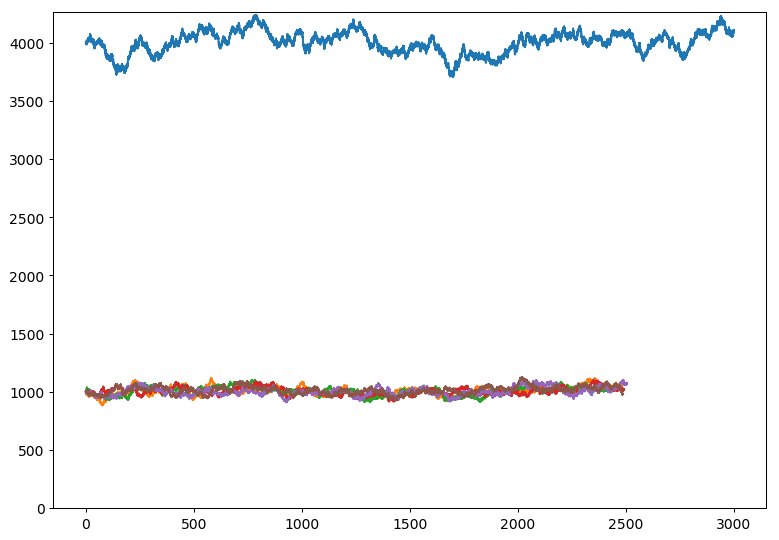

In [102]:
plt.plot(signal['timestamps'], signal['components']['S'])
plt.ylim(0,None)
for response in responses:
    plt.plot(response['timestamps'], response['components']['X'])

In [101]:
variance = []
for i in range(30):
    signal = analyzer.load_trajectory(Path('/data/signal/sig{}.traj'.format(i)))
    variance.append(np.var(signal['components']['S'][::1000]))
np.array(variance).std()

1819.5531275592243

In [106]:
from analyzer.ornstein_uhlenbeck import generate
corr_time = 1
diff_const = 0.285
generate(np.linspace(0, 1000, 1000000), 0, corr_time, diff_const, mean=0)[::1000].var(), corr_time * diff_const

(0.27693800082838527, 0.285)

In [97]:
signal['components']['S'][::10000]

array([4000.        , 3872.1097009 , 3882.27364466, 3883.30806235,
       4059.51643523, 4080.95057292, 4051.11453995, 4136.9556344 ,
       4170.45818198, 3993.70973701, 4084.1138415 , 4020.07931974,
       4097.94836113, 4073.5102347 , 3925.27479799, 3946.32393728,
       4056.36082964, 3719.61015118, 3872.26306693, 3813.24658659,
       4011.9262731 , 3999.73391582, 4048.91473388, 4037.87627053,
       3995.96850478, 4074.7145511 , 3933.02383754, 4001.23749819,
       4010.11003992, 4124.67572393])

In [90]:
import importlib
importlib.reload(analyzer)
importlib.reload(analyzer.ornstein_uhlenbeck);